### Gaussian mixture 

## $\pi (x) = \frac{1}{2(2\pi)^{d/2}} \left( e ^{\frac{-| x-a|^2}{2}}  + e ^{\frac{-| x+a|^2}{2}} \right), \quad x \in\mathbb R^d$

$U(x) = \frac{1}{2} \|x - a\|_2^2 - \text{log}(1 + e^{-2x^\top a})$

$\nabla U(x) = x-a +2a(1 + e^{2 x^\top a})^{-1}$

$ m = 1 - \|a \|_2^2 \quad $ (strongly convex function)

$M = 1 \quad$  (Lipschitz continuous gradient)

$a = (\frac{1}{\sqrt{2d}}, \dots, \frac{1}{\sqrt{2d}})$

##### Setup:

d = 8

n = 1000

N = 50000

N_train = 50

N_test = 100

polynomials_max_deg = 1

$\tilde{n} = 100$

$f(x) = \sum_{i=1}^{d}x_i$

$K = 1$

In [1]:
import numpy as np
import scipy 
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal
from scipy.misc import comb
from matplotlib import pyplot as plt
from scipy.special import hermitenorm
from tqdm import tqdm
from numpy.polynomial.hermite_e import HermiteE
import matplotlib.mlab as mlab
%matplotlib inline
from joblib import Parallel, delayed
from scipy.optimize import minimize
from itertools import product
import sys
import warnings
from sklearn import linear_model
import math
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from numpy.random import normal  
import timeit

### Parameters inicialization, ULA algorithm

In [2]:
d = 8
a = np.ones((d,1)) / np.sqrt(2*d)

def f_grad(x):
    return x-a+2*a/(1 + np.exp(2* (x.T @ a)))

def generate_lmc(a,d,N):
    h = 0.1
    K = 50000
    vkh = np.empty((K + N,d,1))
    ksi = np.random.randn(K+N,d,1)
    vkh[0] = (np.random.normal(0,1,d)).reshape(d,1)
    for i in range(1,K+N):
        grad = f_grad(vkh[i-1])
        vkh[i] = vkh[i-1] - h*grad + np.sqrt(2*h) * ksi[i]
    return vkh[K:], ksi[K:]

### Sample generation

In [3]:
np.random.seed(2342)
X, Z = generate_lmc(a,d, 100000)

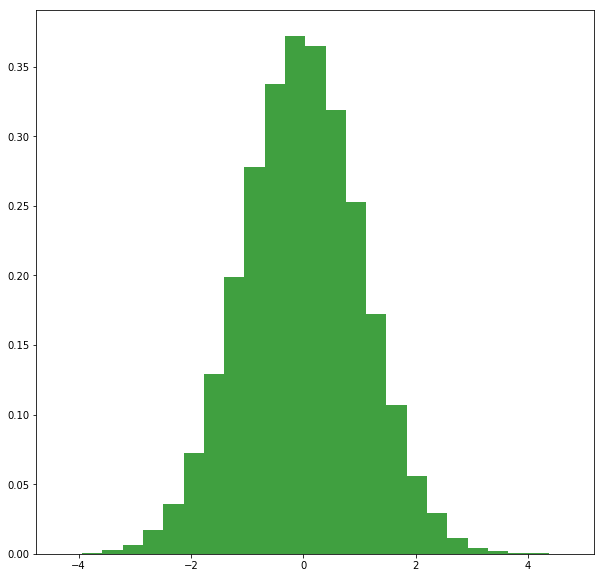

In [4]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(X[:,1].reshape(-1,1), 25, density=True, facecolor='g', alpha=0.75)
x = np.linspace(-5,5,100)
plt.show()

### Ordinary weighted estimator with $$f(x) = x$$

In [5]:
def local_weighted_estimator(X):
    return X.sum(axis = 1).mean()

In [6]:
print ("Weighted estimator = ",local_weighted_estimator(X))

Weighted estimator =  -0.012067186009939047


### Generation of N_train independent paths

In [7]:
def generate_lmc_from_initial(x_initial,a,d,N):
    h = 0.1
    vkh = np.empty((N,d,1))
    ksi = np.random.randn(N,d,1)
    vkh[0] = x_initial
    for i in range(1,N):
        grad = f_grad(vkh[i-1])
        vkh[i] = vkh[i-1] - h*grad + np.sqrt(2*h) * ksi[i]
    return vkh, ksi

def generate_paths(x_initial,N_train,a,d,N):
    XX = []
    ZZ = []
    for i in range(N_train):
        X, Z = generate_lmc_from_initial(x_initial[-i],a,d,N)
        XX.append(X)
        ZZ.append(Z)
    return np.array(XX),np.array(ZZ)

In [108]:
np.random.seed(123)
XX, ZZ = generate_paths(X,50,a,d,1000)

### Generate validation path

In [110]:
np.random.seed(42)
X_validate, Z_validate = generate_lmc_from_initial(X[-5000],a,d,1000)

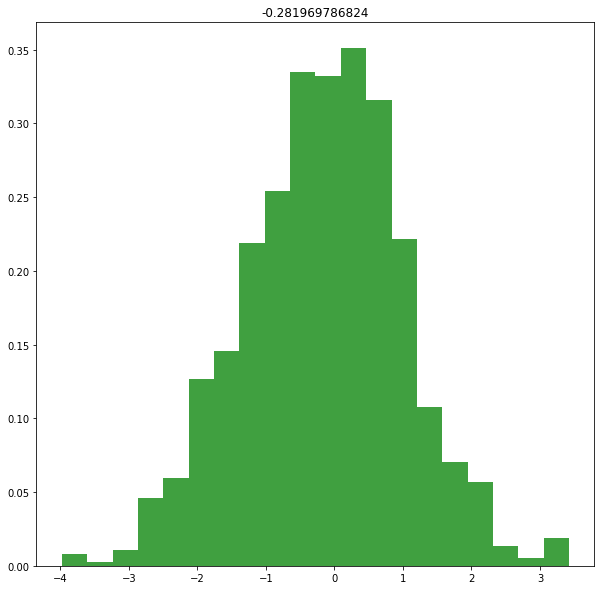

In [111]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(X_validate[:,1].reshape(-1,1), 20, density=True, facecolor='g', alpha=0.75)
x = np.linspace(-5,5,100)
plt.title((local_weighted_estimator(X_validate)))
plt.show()

### (normalized) Hermite polynomials

In [8]:
def generate_k_vec(d, K):
    r = list(range(K+1))
    k = []
    for roll in product(r, repeat = d):
        k.append(list(roll))
    k.remove([0,0,0,0,0,0,0,0])
    return k
def H(k, x):
    h = hermitenorm(k)(x) /  np.sqrt(math.factorial(k))
    return h
def Hermite_val(k_vec,x_vec):
    P = 1.0
    d = x_vec.shape[0]
    for i in range(d):
        P = P * H(k_vec[i],x_vec[i])
    return P

In [9]:
k_comb = np.zeros((d,d), dtype=np.int16)
for i in range(d):
    k_comb[i,i] = 1

### Reduced variant

## Fitting linear regression for 

## $Q_{p,l}(x) = \mathbb{E} \left[f(X_p) | X_l = x\right] = G_{p-l}(x) = \mathbb{E} \left[ f(\varPhi ^{p-l} (x, \xi))\right]$


### $\forall l: \quad G_r(x) = \mathbb{E} \left[f(X_{l+r}) | X_l = x \right] $

### Algorithm (trajectory + all variations):

## $\hat{G}_r = argmin_{\psi \in \Psi} \sum_{s = 1}^{N_{train}} \sum_{l = N + 1}^{N+n-r} \left| f(X_{l+r}^{(s)}) - \psi(X_l^{(s)})\right|^2$

### where $\quad  1 \leq r \leq n-1$

## $\hat{G}_0(x) = f(x)$

In [116]:
def pol_ar_1d(x): #x.shape = (8,1)
    return np.array([1,x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]])

def generate_X_reduced(XX, r):
    N_train = XX.shape[0]
    N = XX.shape[1]
    X = np.empty((N_train * (N-r) ,d+1))
    all_points = XX[:, :N-r].reshape(-1,d)
    X[:,0] = np.ones(N_train * (N-r))
    for i in range(1,X.shape[1]):
        X[:,i] = all_points[:,i-1].squeeze()
    return X 


def generate_y_reduced(XX,r):
    N_train = XX.shape[0]
    N = XX.shape[1]
    y = np.zeros(N_train * (N-r))
    y = XX[:, r:].sum(axis = 2).reshape(-1)
    return y

def G_pml_fit(XX):
    N_train = XX.shape[0]
    N = XX.shape[1]
    Betas = np.zeros((N,9))
    for r in tqdm(range(N)):
        X = generate_X_reduced(XX,r)
        y = generate_y_reduced(XX,r)
        beta = np.linalg.inv(X.T @ X) @ X.T @ y
        Betas[r] = beta
    return Betas

def G_pml_predict(x,pml,Betas):
    x_pol = pol_ar_1d(x)
    beta = Betas[pml]
    return (x_pol @ beta)

In [117]:
Betas_reduced = G_pml_fit(XX)

100%|██████████| 1000/1000 [00:03<00:00, 273.21it/s]


In [119]:
np.save('GM(8d)_Betas_reduced.npy',Betas_reduced)

In [120]:
degrees = np.zeros((d+1,d), dtype=np.int16)
for i in range(1,d+1):
    degrees[i,i-1] = 1

In [121]:
def a_plk(X,p,l,k_vec):
    h = 0.1
    S = 0
    Small_s = np.zeros(8)
    x_hat = X[l-1] - h*f_grad(X[l-1])
    for ind,deg in enumerate(degrees):
        Small_s[:] = 0
        for d, i in enumerate(deg):
            for t in range (i+1):
                for s in range (int(t/2 +1)):
                    if (k_vec[d] == t - 2*s):
                        Small_s[d] = Small_s[d] + comb(N=i, k = t, exact = True) * x_hat[0]**(i-t) * \
                        math.factorial(t)*1/math.factorial(s)*1 / np.sqrt(math.factorial(t-2*s)) *np.sqrt(2*h)**t /2**s
                    else:
                        pass
        S = S + Betas_reduced[p-l,ind] * Small_s.prod()
    return S

In [11]:
def estimator(XX):
    Pi = np.empty(XX.shape[0])
    for i in tqdm(range(XX.shape[0])):
        Pi[i] = local_weighted_estimator(XX[i])
    return Pi

def M_bias(k_vec,X,Z,Betas_reduced,i):
    N = X.shape[0]
    S = 0
    for p in range(N):
        for l in range (p+1):
            if (p-l<100):
                s = a_plk(X,p,l,k_vec)* Hermite_val(k_vec,Z[l])
                S = S + s
    return S/N

def estimator_bias(k,XX,ZZ,Betas,first, last):
    M_results = Parallel(n_jobs=-1)(delayed(M_bias)(k,XX[i],ZZ[i],Betas_reduced,i)for i in range(first, last))
    return np.array(M_results).reshape(-1)

### check formula ( full)

In [98]:
time_1 = timeit.default_timer()
print ("P =",local_weighted_estimator(X_validate))
for i in range(len(k_comb)):
    print ("M ({}) = {} [Time:{}]".format(k_comb[i],M_bias(k_comb[i],X_validate,Z_validate,Betas_reduced,0),
                                           timeit.default_timer()-time_1))

P = -0.281969786824
M ([1, 0, 0, 0, 0, 0, 0, 0]) = [-0.03159257] [Time:219.0979124759324]
M ([0, 1, 0, 0, 0, 0, 0, 0]) = [-0.20742939] [Time:438.8385169659741]
M ([0, 0, 1, 0, 0, 0, 0, 0]) = [-0.27565173] [Time:657.9631948819151]
M ([0, 0, 0, 1, 0, 0, 0, 0]) = [-0.11095527] [Time:877.2312429719605]
M ([0, 0, 0, 0, 1, 0, 0, 0]) = [ 0.3921346] [Time:1096.1146751809865]
M ([0, 0, 0, 0, 0, 1, 0, 0]) = [-0.09290857] [Time:1316.5492193559185]
M ([0, 0, 0, 0, 0, 0, 1, 0]) = [-0.10467204] [Time:1536.5138202869566]
M ([0, 0, 0, 0, 0, 0, 0, 1]) = [ 0.16934347] [Time:1755.132161063957]


## Check on test sample

In [133]:
np.random.seed(987)
X, Z = generate_lmc(a,d,100000)
XX_test, ZZ_test = generate_paths(X,100,a,d,1000)
P_test = estimator(XX_test)

print ('Variance of Pi = ',P_test.var(dtype=np.float64,ddof = 1))

np.save('GM_8d_XX_test.npy', XX_test)
np.save('GM_8d_ZZ_test.npy', ZZ_test)

100%|██████████| 100/100 [00:00<00:00, 22132.36it/s]

Variance of Pi =  0.324733870636


In [12]:
XX_test = np.load('GM_8d_XX_test.npy')
ZZ_test = np.load('GM_8d_ZZ_test.npy')
P_test = estimator(XX_test)

100%|██████████| 100/100 [00:00<00:00, 18999.38it/s]


In [13]:
M_1 = np.load('GM(2d)_M_results_test_1.npy')
M_2 = np.load('GM(2d)_M_results_test_2.npy')
M_3 = np.load('GM(2d)_M_results_test_3.npy')
M_4 = np.load('GM(2d)_M_results_test_4.npy')
M_5 = np.load('GM(2d)_M_results_test_5.npy')
M_6 = np.load('GM(2d)_M_results_test_6.npy')
M_7 = np.load('GM(2d)_M_results_test_7.npy')
M_8 = np.load('GM(2d)_M_results_test_8.npy')

In [14]:
M_results = np.stack((M_1, M_2, M_3, M_4,M_5,M_6,M_7,M_8))

In [17]:
np.save('GM(2d)_M_results_test_.npy', M_results)

In [19]:
# for i in range(d):
#     M_results[i] = estimator_bias(k_comb[i],XX_test,ZZ_test,Betas, 0, 100)
# np.save('BLR(8d)_M_results_test.npy',M_results)
M_results = np.load('GM(2d)_M_results_test_.npy')

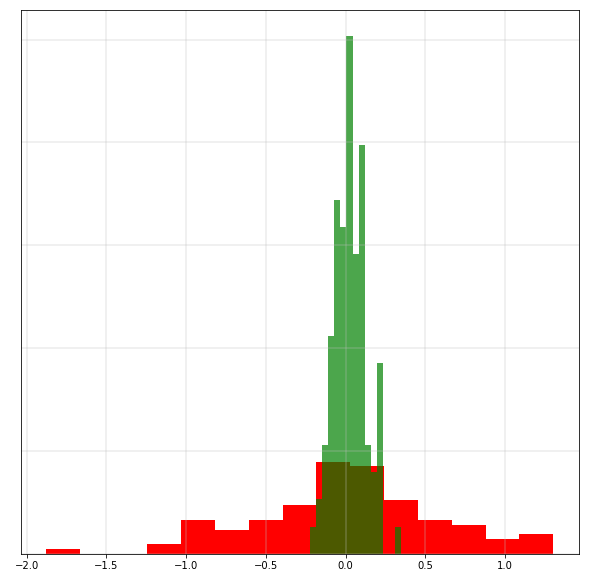

In [20]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(P_test.reshape(-1,1),15,facecolor='r', density=True,
                            alpha=1, label=r"$\pi$")

n, bins, patches = plt.hist((P_test-M_results.sum(axis=0)).reshape(-1,1),15, density=True, facecolor='g', 
                            alpha=0.7, label="Distribution of $\pi - M^1_N$")

#plt.legend(loc=2, prop={'size': 17})
plt.grid(which='major', axis='x', linewidth=0.45, linestyle='-', color='0.75')
plt.grid(which='major', axis='y', linewidth=0.45, linestyle='-', color='0.75')

plt.tick_params(
    axis='y',
    color = 'w',
    labelcolor = 'w',
    which='both')
# plt.xlim(-0.5, 0.5)
plt.show()

In [21]:
print ('               Variance of Pi = ',P_test.var(ddof = 1))
for i in range(1,d+1):
    print ('Variance of new estimator (K=1)=',(P_test-M_results[:i].sum(axis = 0)).var(ddof = 1))

               Variance of Pi =  0.3247338706361704
Variance of new estimator (K=1)= 0.2869924799887466
Variance of new estimator (K=1)= 0.2632394934159166
Variance of new estimator (K=1)= 0.21623564939038256
Variance of new estimator (K=1)= 0.17530225999167218
Variance of new estimator (K=1)= 0.12154329522171337
Variance of new estimator (K=1)= 0.11262402002048291
Variance of new estimator (K=1)= 0.05343949733839273
Variance of new estimator (K=1)= 0.00978211277392896


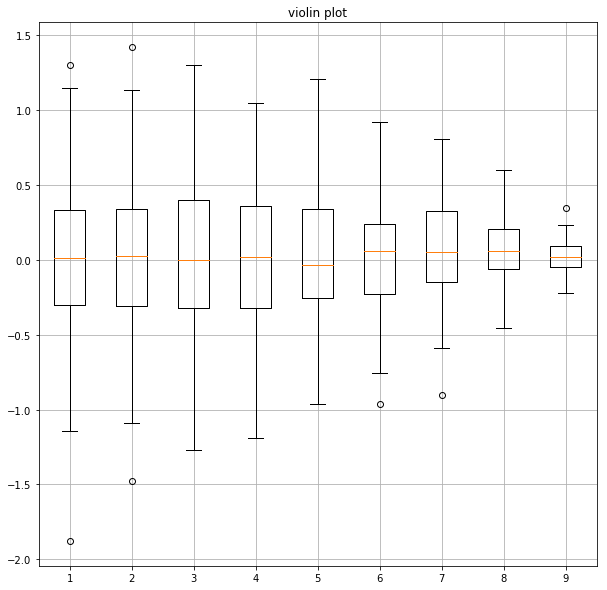

In [22]:
all_data = [P_test]
for i in range(1,d+1):
    all_data.append(P_test - M_results[:i].sum(axis = 0))
    
plt.figure(figsize=(10,10))
plt.boxplot(all_data)
plt.title('violin plot')
plt.grid()
plt.show()